# ***Assignment 1.2 - CAVI***
Consider the model defined by Equation (10.21)-(10-23) in Bishop, for which DGM is presented below:

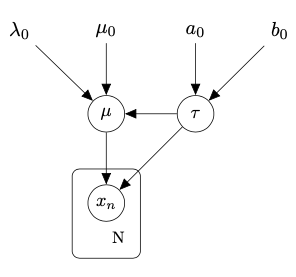

### ***Question 1.2.7:***

Implement a function that generates data points for the given model.

In [437]:
import numpy as np
import matplotlib.pyplot as plt
def generate_data(mu, tau, size):
    variance = 1 / tau
    return np.random.normal(mu, np.sqrt(variance), size)


Set μ = 1, τ = 0.5 and generate datasets with size N=10,100,1000. Plot the histogram for each of 3
datasets you generated.



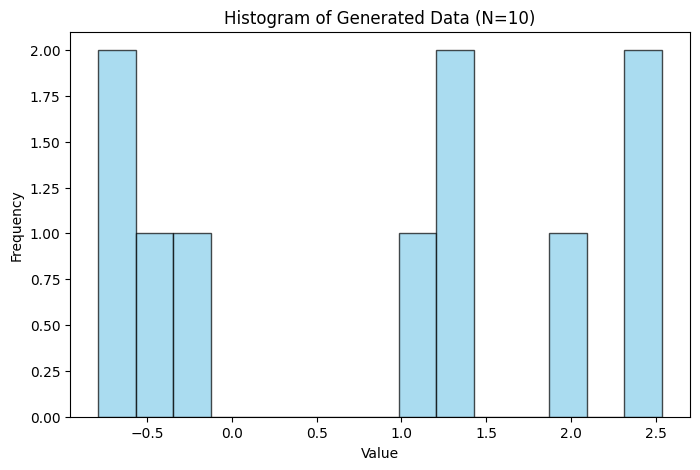

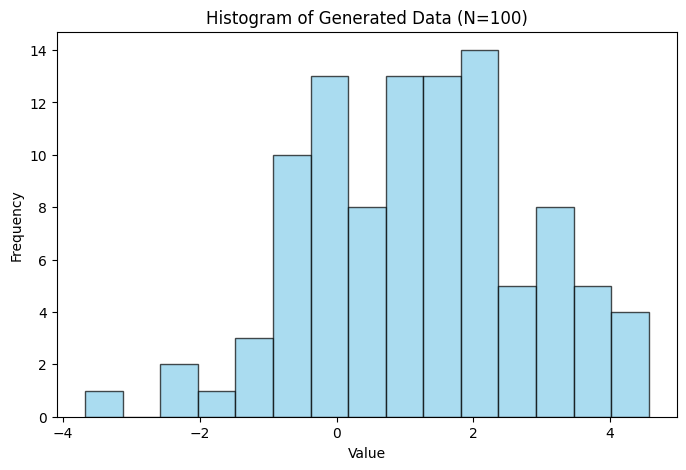

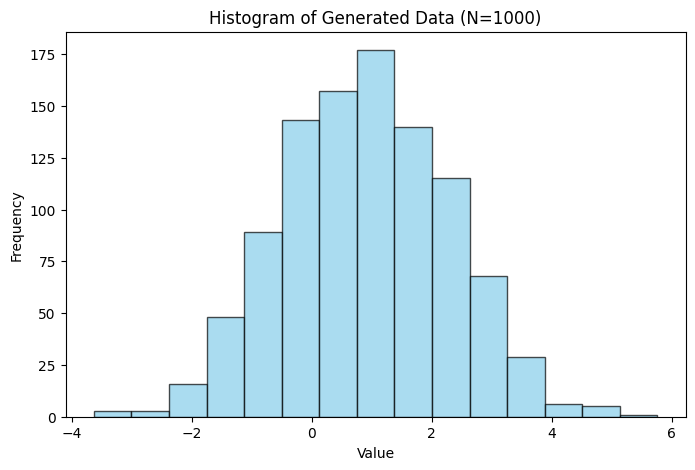

In [438]:
mu = 1
tau = 0.5
sizes = [10, 100, 1000]

datasets = {size: generate_data(mu, tau, size) for size in sizes}

# Visulaize the datasets via histograms
for size, data in datasets.items():
    plt.figure(figsize=(8, 5))
    plt.hist(data, bins=15, color='skyblue', alpha=0.7, edgecolor='black')
    plt.title(f"Histogram of Generated Data (N={size})")
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.savefig(f"figures/{size}_histogram.pdf")
    plt.show()


### ***Question 1.2.8:***

Find ML estimates of the variables μ and τ

In [439]:
def ML_est(data):
  mu_ml = np.mean(data)
  tau_ml = 1 / np.var(data)
  return mu_ml, tau_ml

ml_estimates = {size: ML_est(data) for size, data in datasets.items()}

import pandas as pd
ml_results = pd.DataFrame.from_dict(
    ml_estimates, orient='index', columns=['ML Estimate of μ', 'ML Estimate of τ']
)

print(ml_results)

      ML Estimate of μ  ML Estimate of τ
10            0.823837          0.711253
100           1.181637          0.380573
1000          0.897017          0.527485


### ***Question 1.2.9:***

What is the exact posterior? First derive it in closed form, and then implement a function that computes it for the given parameters:


In [440]:
def compute_exact_posterior(D, a_0, b_0, mu_0, lambda_0):
  N = len(D)
  x_mean = np.mean(D)
  lambda_N = lambda_0 + N
  a_N = a_0 + N / 2
  mu_N = (lambda_0 * mu_0 + np.sum(D)) / (lambda_0 + N)
  # Same expressions from derivation and from wikipedia - exact same value returned
  b_N = b_0 + 1/2 * (np.sum(np.power(D,2)) + lambda_0*mu_0**2 - lambda_N*mu_N**2)
  #b_N = b_0 + 1/2 * np.sum(np.power(D-x_mean,2)) + N*lambda_0/(N+lambda_0) * ((x_mean - mu_0)**2)/2

  return {"a_N": a_N, "b_N": b_N, "mu_N": mu_N, "lambda_N": lambda_N}


print(compute_exact_posterior(datasets[1000],0,1,1,0.5))

{'a_N': 500.0, 'b_N': np.float64(948.8969105904703), 'mu_N': np.float64(0.8970685524904668), 'lambda_N': 1000.5}


### ***Question 1.2.10:***
You will implement the VI algorithm for the variational distribution in Equation (10.24) in Bishop. Start with introducing the prior parameters:

In [441]:
# prior parameters
mu_0 = 0
lambda_0 = 1
a_0 = 1
b_0 = 1

Continue with a helper function that computes ELBO:


In [442]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import digamma, gammaln
from scipy.special import psi, gammaln

def elbo(x, mu_N, lambda_N, a_N, b_N):
    
    N = len(x)
    
    # Expectations for tau
    E_log_tau = psi(a_N) - np.log(b_N)
    E_tau = a_N / b_N

    # Likelihood term
    E_log_p_x_given_mu_tau = (N / 2) * E_log_tau - 0.5 * E_tau * np.sum(x**2 - 2 * x * mu_N + mu_N**2 + 1 / lambda_N)

    # Prior on mu
    E_log_p_mu_given_tau = -0.5 * E_tau * ((mu_N - mu_0)**2 + 1 / lambda_0)

    # Prior on tau
    E_log_p_tau = (a_0 - 1) * E_log_tau - b_0 * E_tau - gammaln(a_0) + a_0 * np.log(b_0)

    # ELBO
    elbo_val = E_log_p_x_given_mu_tau + E_log_p_mu_given_tau + E_log_p_tau
    
    return elbo_val





Now, implement the CAVI algorithm:

In [443]:
def CAVI(x, mu_0, lambda_0, a_0, b_0):
    
    # Helpers for calculating updates:
    def update_mu(x, mu_0, lambda_0, E_tau):
        # Update mu, tau from Bishop (10.26, 10.27)
        N = len(x)
        lambda_N = (lambda_0 + N) * E_tau
        mu_N = (N*np.mean(x) + lambda_0 * mu_0) / (lambda_0 + N)
        return mu_N, lambda_N
    
    def update_tau(x, mu_N, a_0, b_0, lambda_0, lambda_N):
        # Update a_N, b_N from the approximations in Bishop (10.29, 10.30)
        
        N = len(x)
        a_N = a_0 + (N + 1) / 2
        
        # b_N:s expected mu values
        expected_x_mu_squared = np.sum(x**2 - 2 * x * mu_N + (1 / lambda_N) + mu_N**2)
        expected_mu_mu0_squared = (1 / lambda_N) + mu_N**2 - 2 * mu_0 * mu_N + mu_0**2

        b_N = b_0 + 0.5 * (expected_x_mu_squared + lambda_0 * expected_mu_mu0_squared)

        return a_N, b_N
    
    # Parameter priors
    mu_N = mu_0  
    lambda_N = lambda_0
    a_N = a_0
    b_N = b_0

    elbo_history = [elbo(x, mu_N, lambda_N, a_N, b_N)]
    mu_history = [mu_N]
    lambdas_history = [lambda_N]
    estimated_taus_history = [a_N/b_N]

    prev_elbo = -np.inf
    for i in range(100):
        # Update mu and lambda
        E_tau = a_N/b_N
        
        mu_N, _ = update_mu(x, mu_N, lambda_N, E_tau)
        _, lambda_N = update_mu(x, mu_N, lambda_N, E_tau)
        
        a_N, _ = update_tau(x, mu_N, a_N, b_N, lambda_0, lambda_N)
        _, b_N = update_tau(x, mu_N, a_N, b_N, lambda_0, lambda_N)

        elbo_value = elbo(x, mu_N, lambda_N, a_N, b_N)

        elbo_history.append(elbo_value)
        mu_history.append(mu_N)
        lambdas_history.append(lambda_N)
        estimated_taus_history.append(a_N/b_N)

        print(f"Iteration {i+1}: ELBO = {elbo_value}")

        # Early break
        if np.abs(elbo_value - prev_elbo) < 1e-6:
            print(f"Converged after {i+1} iterations.")
            return {"a_N": a_N, "b_N": b_N, "mu_N": mu_N, "lambda_N": lambda_N, "elbos": elbo_history, "mus": mu_history, "lambdas": lambdas_history, "taus": estimated_taus_history}

        prev_elbo = elbo_value

    return {"a_N": a_N, "b_N": b_N, "mu_N": mu_N, "lambda_N": lambda_N, "elbos": elbo_history, "mus": mu_history, "lambdas": lambdas_history, "taus": estimated_taus_history}

Run the VI algorithm on the datasets. Compare the inferred variational
distribution with the exact posterior and the ML estimate. Visualize the results and discuss your
findings.


In [444]:
def plot_results(cavi_results,dataset):
    N = len(dataset)
    elbo_history = cavi_results["elbos"]
    mu_history = cavi_results["mus"]
    taus_history = cavi_results["taus"]
    
    # Plot ELBO over iterations
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(elbo_history, label='ELBO')
    plt.title(f'N = {N}, ELBO Evolution')
    plt.xlabel('Iterations')
    plt.ylabel('ELBO')
    plt.grid(True)
    plt.legend()

    # mu, tau over iterations
    plt.subplot(1, 2, 2)
    plt.plot(mu_history, label='$\mu_N$', color='blue')
    plt.plot(taus_history, label='$a_N/b_N$', color='orange')
    plt.title(f'N = {N}, Variational Parameters Evolution')
    plt.xlabel('Iterations')
    plt.ylabel('Parameter Value')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.savefig(f"figures/{N}_ELBOandMuTau.pdf")
    plt.show()
    
    posterior_params = compute_exact_posterior(dataset, a_0, b_0, mu_0, lambda_0)
    ml_estimates = ML_est(dataset)

    plt.figure(figsize=(8, 5))
    # Exact posterior mean and precision
    plt.axvline(posterior_params["mu_N"], color="g", linestyle="--", label="Exact Posterior (Mean)")
    print(f"Posterior mu: {posterior_params["mu_N"]}")
    # CAVI mean
    plt.axvline(cavi_results["mu_N"], color="b", linestyle=":", label="CAVI (Mean)")
    print(f"CAVI mu: {cavi_results["mu_N"]}")
    # ML estimate
    plt.axvline(ml_estimates[0], color="r", linestyle="-", label="ML Estimate (Mean)")
    print(f"ML mu: {ml_estimates[0]}")
    plt.title(f"N = {N}, Comparison of Posterior, CAVI, and ML")
    plt.xlabel("Mean (μ)")
    plt.legend()
    plt.grid()
    
    #plt.figure(figsize=(8, 5))
    # Exact posterior mean and precision
    plt.axvline(posterior_params["a_N"]/posterior_params["b_N"], color="g", linestyle="--", label="Exact Posterior (tau)")
    print(f"Posterior tau: {posterior_params["a_N"]/posterior_params["b_N"]}")
    # CAVI mean
    plt.axvline(cavi_results["taus"][-1], color="b", linestyle=":", label="CAVI (tau)")
    print(f"CAVI tau: {cavi_results["taus"][-1]}")
    # ML estimate
    plt.axvline(ml_estimates[1], color="r", linestyle="-", label="ML Estimate (tau)")
    print(f"ML tau: {ml_estimates[1]}")
    plt.title(f"N = {N}, Comparison of Posterior, CAVI, and ML")
    plt.xlabel("Value")
    plt.legend()
    plt.grid()
    plt.savefig(f"figures/{N}MLexactCAVIcomp.pdf")
    plt.show()

<>:19: SyntaxWarning: invalid escape sequence '\m'
<>:19: SyntaxWarning: invalid escape sequence '\m'
/var/folders/7t/7qxxs14161512g3d5tsqp_xw0000gn/T/ipykernel_51458/247895124.py:19: SyntaxWarning: invalid escape sequence '\m'
  plt.plot(mu_history, label='$\mu_N$', color='blue')


Iteration 1: ELBO = -8.765229514270752
Iteration 2: ELBO = -8.467921787530164
Iteration 3: ELBO = -8.363216127769132
Iteration 4: ELBO = -8.310799483569722
Iteration 5: ELBO = -8.279857445869373
Iteration 6: ELBO = -8.259727701419695
Iteration 7: ELBO = -8.245756466306746
Iteration 8: ELBO = -8.235595978240514
Iteration 9: ELBO = -8.227937847097136
Iteration 10: ELBO = -8.221998069524858
Iteration 11: ELBO = -8.217280335187722
Iteration 12: ELBO = -8.213456709331979
Iteration 13: ELBO = -8.210302968323344
Iteration 14: ELBO = -8.207661452080758
Iteration 15: ELBO = -8.205418681248286
Iteration 16: ELBO = -8.203491327082926
Iteration 17: ELBO = -8.201817122076848
Iteration 18: ELBO = -8.200348805900246
Iteration 19: ELBO = -8.199049997326107
Iteration 20: ELBO = -8.197892322477998
Iteration 21: ELBO = -8.19685338221802
Iteration 22: ELBO = -8.195915291550689
Iteration 23: ELBO = -8.195063615873263
Iteration 24: ELBO = -8.194286586797622
Iteration 25: ELBO = -8.193574517601638
Iteration 

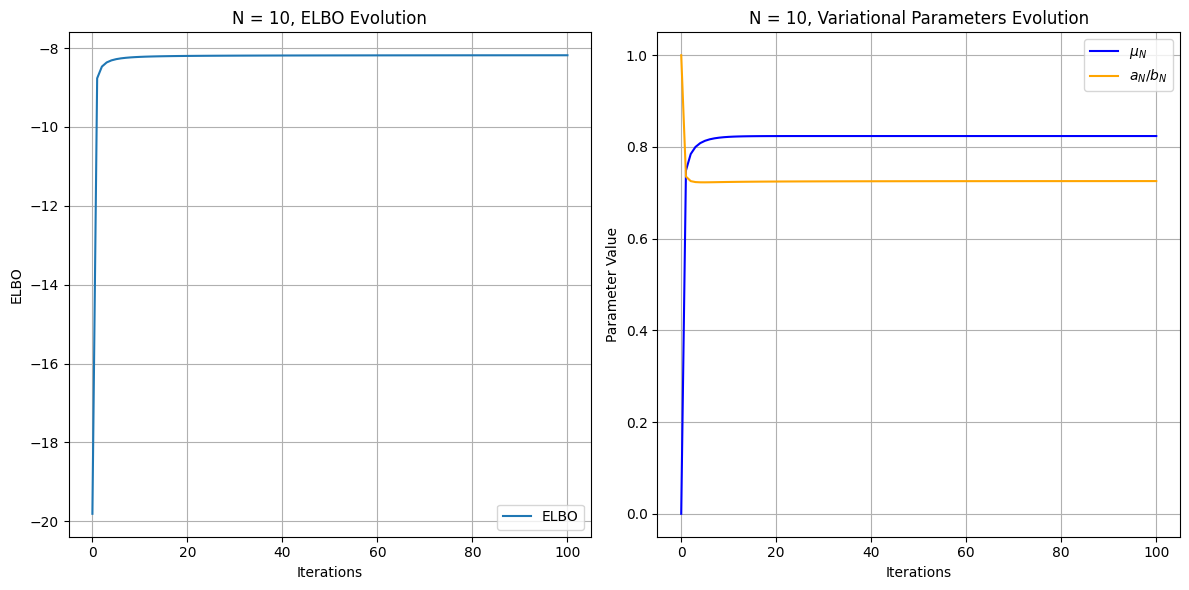

Posterior mu: 0.7489423547076385
CAVI mu: 0.8238365901784017
ML mu: 0.8238365901784024
Posterior tau: 0.7195671258260807
CAVI tau: 0.725585798081505
ML tau: 0.7112533964685769


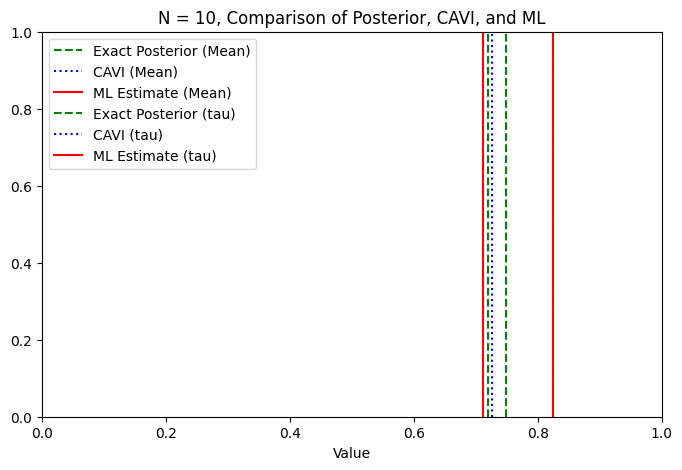

Iteration 1: ELBO = -99.83083473464107
Iteration 2: ELBO = -99.63747419285103
Iteration 3: ELBO = -99.58823300468723
Iteration 4: ELBO = -99.56288223040382
Iteration 5: ELBO = -99.54483088470565
Iteration 6: ELBO = -99.53097825456406
Iteration 7: ELBO = -99.52018975553054
Iteration 8: ELBO = -99.51169856923475
Iteration 9: ELBO = -99.50492186823878
Iteration 10: ELBO = -99.4994267246209
Iteration 11: ELBO = -99.49489872797704
Iteration 12: ELBO = -99.49111107350781
Iteration 13: ELBO = -99.48789934275572
Iteration 14: ELBO = -99.48514294307391
Iteration 15: ELBO = -99.48275209518245
Iteration 16: ELBO = -99.48065888207437
Iteration 17: ELBO = -99.47881110715183
Iteration 18: ELBO = -99.4771680513295
Iteration 19: ELBO = -99.4756975071593
Iteration 20: ELBO = -99.47437367586001
Iteration 21: ELBO = -99.47317565349009
Iteration 22: ELBO = -99.47208632471434
Iteration 23: ELBO = -99.471091542668
Iteration 24: ELBO = -99.47017951261088
Iteration 25: ELBO = -99.46934032283512
Iteration 26: 

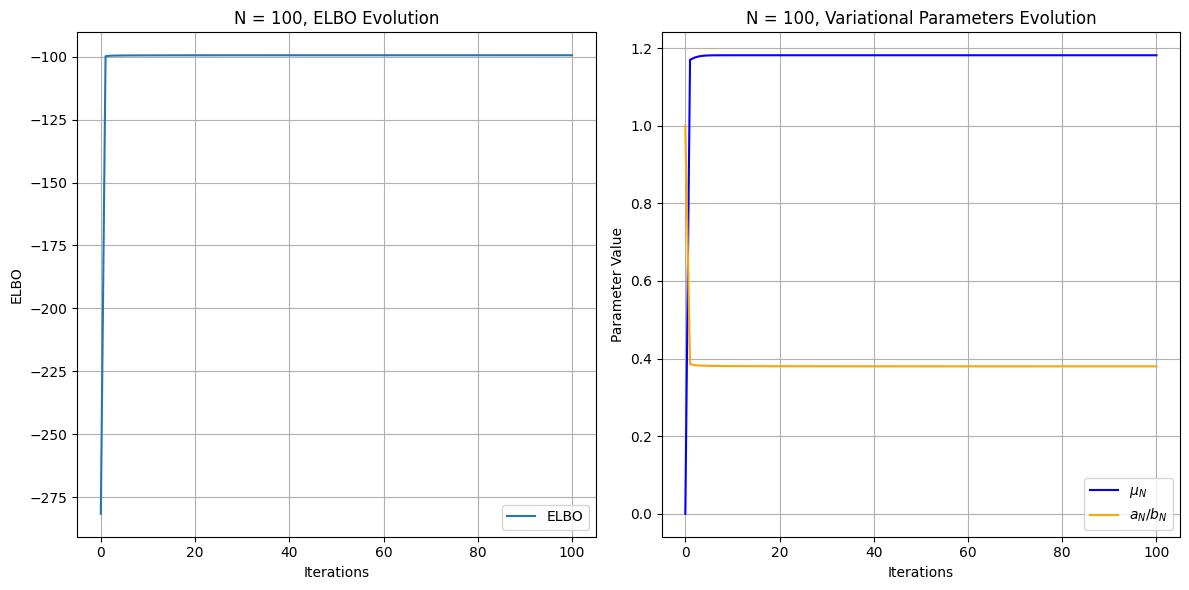

Posterior mu: 1.1699375709492752
CAVI mu: 1.1816369466587677
ML mu: 1.181636946658768
Posterior tau: 0.38325107062664393
CAVI tau: 0.3800440344406415
ML tau: 0.3805730704492566


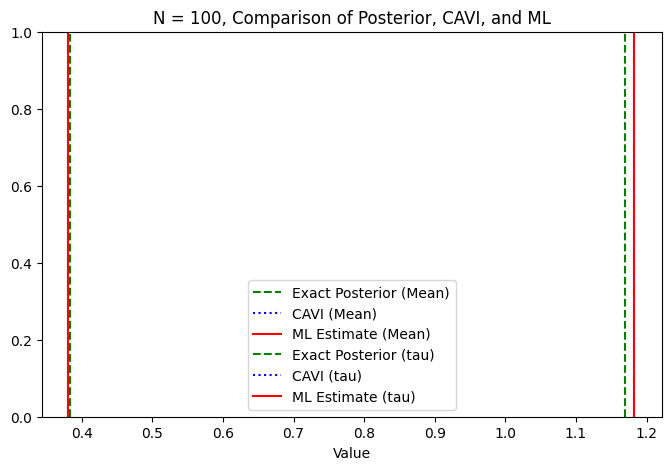

Iteration 1: ELBO = -821.5843130167482
Iteration 2: ELBO = -821.3206255976029
Iteration 3: ELBO = -821.2307016791624
Iteration 4: ELBO = -821.1857309874343
Iteration 5: ELBO = -821.1590385450614
Iteration 6: ELBO = -821.1414957152684
Iteration 7: ELBO = -821.1291351944468
Iteration 8: ELBO = -821.1199691959984
Iteration 9: ELBO = -821.1129011468666
Iteration 10: ELBO = -821.1072813973984
Iteration 11: ELBO = -821.1027027435181
Iteration 12: ELBO = -821.0988978045698
Iteration 13: ELBO = -821.0956839917806
Iteration 14: ELBO = -821.0929323783301
Iteration 15: ELBO = -821.090549279837
Iteration 16: ELBO = -821.0884649210802
Iteration 17: ELBO = -821.0866262169645
Iteration 18: ELBO = -821.084992029385
Iteration 19: ELBO = -821.083529963006
Iteration 20: ELBO = -821.0822141460068
Iteration 21: ELBO = -821.0810236583694
Iteration 22: ELBO = -821.0799413963601
Iteration 23: ELBO = -821.0789532374354
Iteration 24: ELBO = -821.0780474162087
Iteration 25: ELBO = -821.0772140514647
Iteration 26

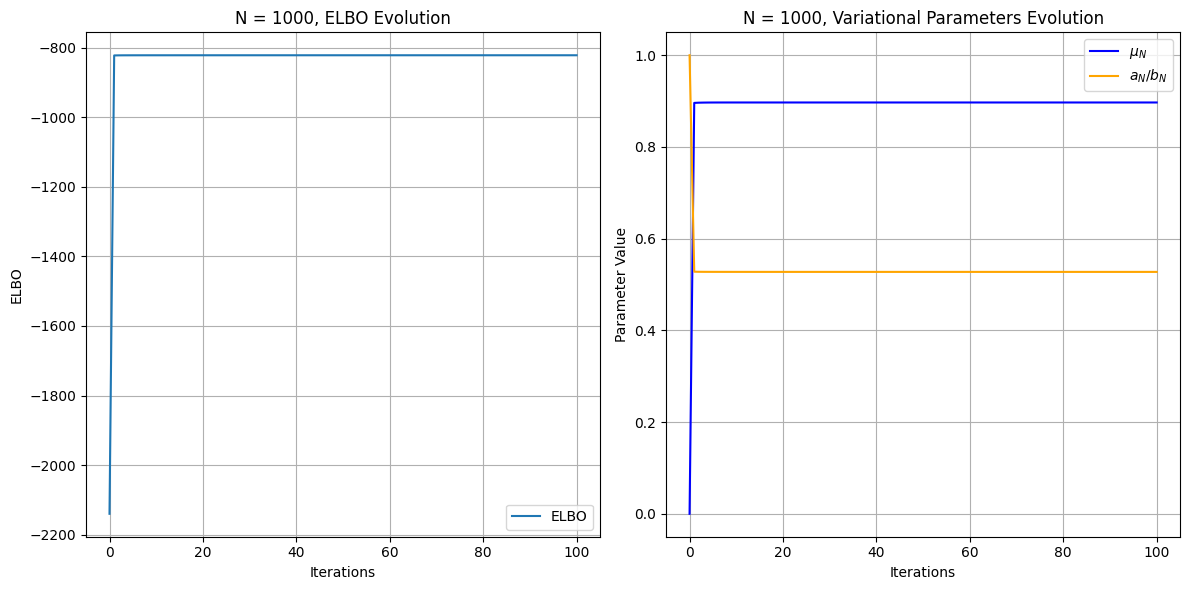

Posterior mu: 0.8961209658009112
CAVI mu: 0.897017086766712
ML mu: 0.8970170867667121
Posterior tau: 0.527759419421319
CAVI tau: 0.5275435318331776
ML tau: 0.5274849957550284


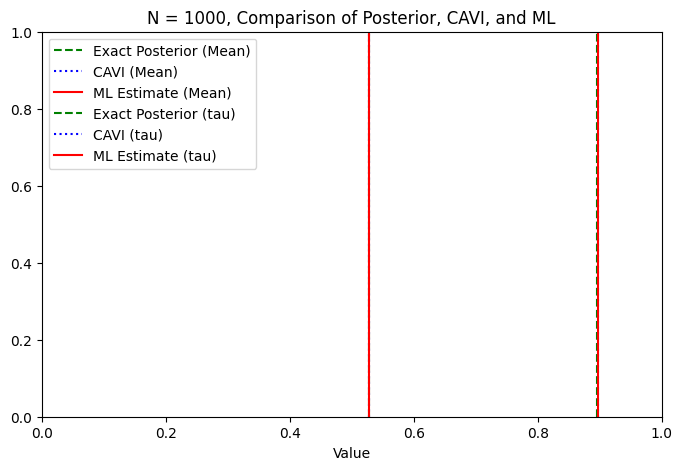

In [445]:
for data in datasets.values():
    cavi_results = CAVI(data, mu_0, lambda_0, a_0, b_0)
    plot_results(cavi_results,data)